**Anomaly Detection Algorithm using Gaussian Mixture Model**

##**Part 1: Getting started**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`.

In [ ]:
pip install wget

In [ ]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (1).gz'

In [ ]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [ ]:
df.describe

<bound method NDFrame.describe of             Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...  0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99      0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00      0

[284807 rows x 31 columns]>

In [ ]:
print(np.array(df['Class']))

[0 0 0 ... 0 0 0]


In [ ]:
numpy_class_column = np.array(df['Class'])
number_of_ones = np.count_nonzero(numpy_class_column)
print(number_of_ones)
number_of_zeros = len(numpy_class_column) - number_of_ones
print(number_of_zeros)
dataset_len = (len(numpy_class_column))


492
284315


Next, split the dataset into a training (65%), validation (20%) and testing set (15%). Set the random state to 40. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [ ]:
x = df.drop(['Class'],axis=1)
y = df['Class']

In [ ]:
### Split the data  ###

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=40)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,train_size= (0.65*dataset_len)/float((X_train.shape)[0]), random_state=40)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,X_val.shape,y_val.shape)



(242085, 30) (42722, 30) (242085,) (42722,)
(185124, 30) (42722, 30) (185124,) (42722,) (56961, 30) (56961,)


Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

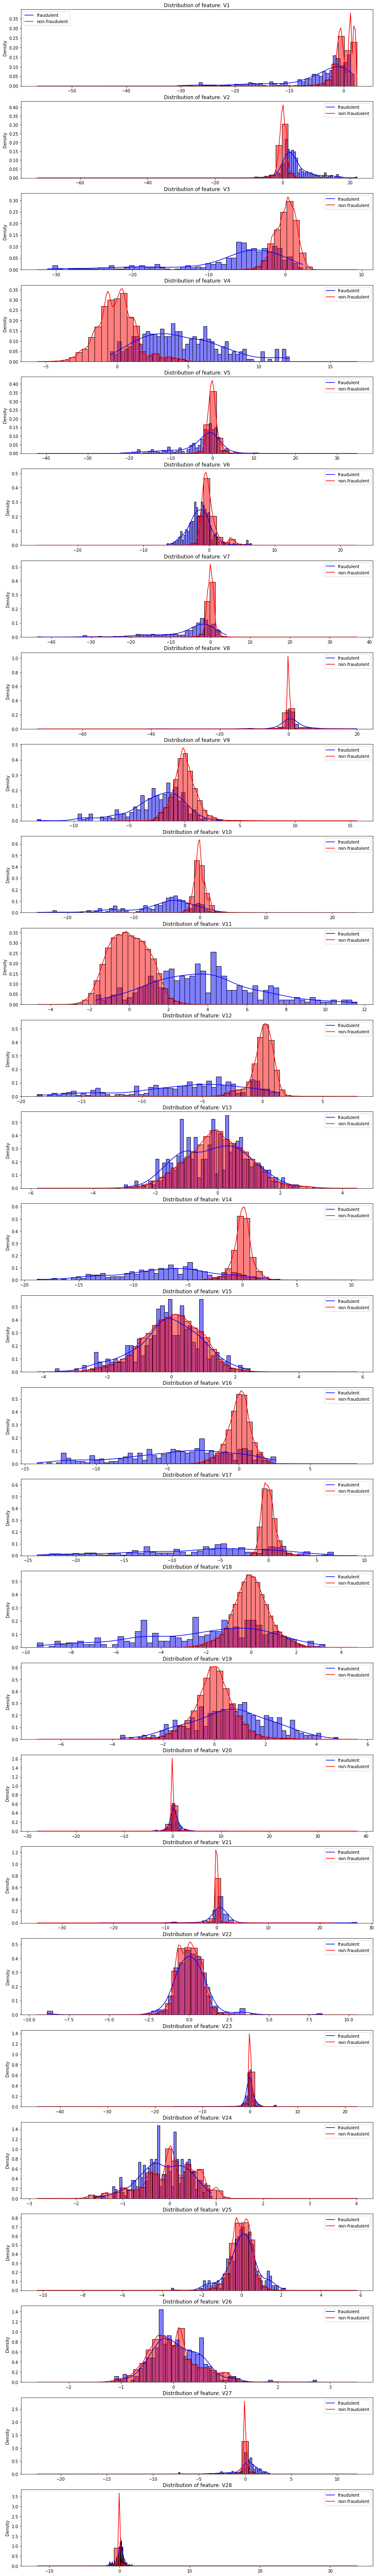

In [ ]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

From the graph we can find how the distribution is for fraudent and non-fraudent classes for each feature. Few of the features have the distributions very close to each other. Like V23, V25, V26 have fraudent and non fraudent distributions very close to each other ie they won't give good predictions.
Whereas in some features like V12, V5 the distributions are far away, ie their mean and variance are different, hence can be used for learning, and also might give good predictions.

## **Part 2: One Gaussian model with Single feature:**

Please note that we **only use `V` features** in our model.


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score

#creating a modal which will fit only one feature
gm = GaussianMixture(n_components = 1,random_state=0)

auc_train_score = []
auc_val_score = []

features=[f for f in df.columns if 'V' in f]
# features
for item in features:
  data_train = X_train[item].values.reshape(X_train[item].shape[0],1)
  data_val = X_val[item].values.reshape(X_val[item].shape[0],1)
  #fitting one feature
  gm.fit(data_train)

  #likelihood of each sample is computed using score samples
  score_train = gm.score_samples(data_train)
  score_val = gm.score_samples(data_val)

  #computing the auc on training and validation set
  auc_train_score.append(roc_auc_score(y_train, -1*score_train))
  auc_val_score.append(roc_auc_score(y_val, -1*score_val))


In [ ]:
from sklearn.metrics import f1_score

#finding the best 3 features for prediction
index_of_three_best_features = np.argsort(np.array(auc_val_score))[-3:]
# print(index_of_three_best_features)
column_name_of_three_best_features = np.array(features)[index_of_three_best_features]
print('The best features of validation set ---> ',column_name_of_three_best_features)
print('The AUC values of these features respectively is ---> ',auc_val_score[index_of_three_best_features[0]],auc_val_score[index_of_three_best_features[1]],auc_val_score[index_of_three_best_features[2]])

The best features of validation set --->  ['V10' 'V17' 'V14']
The AUC values of these features respectively is --->  0.9172900697942519 0.9256990719043909 0.9550660060714344


In [ ]:
f1_scores = []
optimal_threshold = []
for item in column_name_of_three_best_features:
  gm.fit(X_train[item].values.reshape(-1,1))
  data_val = gm.score_samples(X_val[item].values.reshape(-1,1))

  #removing the duplicates from the generated scores/thresholds which will help to improve the computation speed
  threshold_sorted = np.unique(data_val)

  max_f1_score = 0
  best_threshold = 0

  #loop to find the optimal threshold by maximizing the f1 score
  for threshold in threshold_sorted:
    outliers = np.nonzero(data_val<threshold)[0]
    y_pred = np.zeros(y_val.shape)
    # print("y_pred-->",y_pred)
    y_pred[outliers] = 1
    f1_temp = f1_score(y_val, y_pred)
    if f1_temp<max_f1_score*0.8:
        break
    if f1_temp>max_f1_score:
        max_f1_score = f1_temp
        best_threshold = threshold
  f1_scores.append(max_f1_score)
  optimal_threshold.append(best_threshold)
  print('Feature Name -->',item,',  Optimal threshold -->',best_threshold,', Maximum F1 score --> ',max_f1_score)


Feature Name --> V10 ,  Optimal threshold --> -27.74250491605403 , Maximum F1 score -->  0.21296296296296297
Feature Name --> V17 ,  Optimal threshold --> -22.026448707076476 , Maximum F1 score -->  0.5977011494252873
Feature Name --> V14 ,  Optimal threshold --> -19.241703831870105 , Maximum F1 score -->  0.6192893401015229


In [ ]:
#finding precison, recall and f1 score using the threshold calculated from the previous steps.
from sklearn.metrics import precision_score, recall_score, f1_score

all_values = []

for i in range(0,3):
  gm.fit(X_train[column_name_of_three_best_features[i]].values.reshape(-1,1))
  gm_score = gm.score_samples(X_train[column_name_of_three_best_features[i]].values.reshape(-1,1))
  t_pre = precision_score(y_train,gm_score<=optimal_threshold[i])
  t_rec = recall_score(y_train, gm_score<=optimal_threshold[i])
  t_f1 = f1_score(y_train, gm_score<=optimal_threshold[i])
  temp = [t_pre,t_rec,t_f1]
  all_values.append(temp)

result_train = pd.DataFrame(np.array(all_values),columns=["Training Precision","Training Recall","Training F1 Score"],index = column_name_of_three_best_features)

all_values = []

for i in range(0,3):
  gm.fit(X_val[column_name_of_three_best_features[i]].values.reshape(-1,1))
  gm_score = gm.score_samples(X_val[column_name_of_three_best_features[i]].values.reshape(-1,1))
  t_pre = precision_score(y_val,gm_score<=optimal_threshold[i])
  t_rec = recall_score(y_val, gm_score<=optimal_threshold[i])
  t_f1 = f1_score(y_val, gm_score<=optimal_threshold[i])
  temp = [t_pre,t_rec,t_f1]
  all_values.append(temp)

result_val = pd.DataFrame(np.array(all_values),columns=["Training Precision","Training Recall","Training F1 Score"],index = column_name_of_three_best_features)

In [ ]:
# precision, recall and f1 score --> Training set
result_train


,Training Precision,Training Recall,Training F1 Score
V10,0.184466,0.236025,0.207084
V17,0.653061,0.496894,0.564374
V14,0.616667,0.574534,0.594855


In [ ]:
# precision, recall and f1 score --> validation set
result_val

,Training Precision,Training Recall,Training F1 Score
V10,0.186992,0.225490,0.204444
V17,0.712329,0.509804,0.594286
V14,0.628866,0.598039,0.613065


In [ ]:
#calculating auc for the best 3 features found in previous step

f1_scores_best_features = []
optimal_threshold_best_features = []

auc_train_score_best_features = []
auc_val_score_best_features = []

for item in column_name_of_three_best_features:
  train_non_fraudent = X_train[y_train==0][item].values.reshape(-1, 1)
  gm.fit(train_non_fraudent)
  data_val = gm.score_samples(X_val[item].values.reshape(-1,1))
  data_train = gm.score_samples(X_train[item].values.reshape(-1,1))

  auc_train_score_best_features.append(roc_auc_score(y_train, -1*data_train))
  auc_val_score_best_features.append(roc_auc_score(y_val, -1*data_val))
    
  threshold_sorted = np.unique(data_val)
  max_f1_score = 0
  best_threshold = 0
  for threshold in threshold_sorted:
    outliers = np.nonzero(data_val<threshold)[0]
    y_pred = np.zeros(y_val.shape)
    y_pred[outliers] = 1
    f1_temp = f1_score(y_val, y_pred)
    if f1_temp<max_f1_score*0.8:
        break
    if f1_temp>max_f1_score:
        max_f1_score = f1_temp
        best_threshold = threshold
  f1_scores_best_features.append(max_f1_score)
  optimal_threshold_best_features.append(best_threshold)
  print('Feature ---> ',item,', Optimal threshold ---> ',best_threshold,', Maximum F1 score --->',max_f1_score)


Feature --->  V10 , Optimal threshold --->  -29.987306415434826 , Maximum F1 score ---> 0.21296296296296297
Feature --->  V17 , Optimal threshold --->  -27.540108652785015 , Maximum F1 score ---> 0.5977011494252873
Feature --->  V14 , Optimal threshold --->  -21.84751940628064 , Maximum F1 score ---> 0.6192893401015229


In [ ]:
#calculating precision, recall and f1 score on training and validation set only for non-fraudulent class.

from sklearn.metrics import precision_score, recall_score, f1_score
all_values_non_fraud = []

for i in range(0,3):
  gm.fit(X_train[column_name_of_three_best_features[i]].values.reshape(-1,1))
  gm_score = gm.score_samples(X_train[column_name_of_three_best_features[i]].values.reshape(-1,1))
  t_pre = precision_score(y_train,gm_score<=optimal_threshold_best_features[i])
  t_rec = recall_score(y_train, gm_score<=optimal_threshold_best_features[i])
  t_f1 = f1_score(y_train, gm_score<=optimal_threshold_best_features[i])
  temp = [t_pre,t_rec,t_f1]
  all_values_non_fraud.append(temp)

result_train_non_fraud = pd.DataFrame(np.array(all_values_non_fraud),columns=["Training Precision","Training Recall","Training F1 Score"],index = column_name_of_three_best_features)

all_values_non_fraud = []

for i in range(0,3):
  gm.fit(X_val[column_name_of_three_best_features[i]].values.reshape(-1,1))
  gm_score = gm.score_samples(X_val[column_name_of_three_best_features[i]].values.reshape(-1,1))
  t_pre = precision_score(y_val,gm_score<=optimal_threshold_best_features[i])
  t_rec = recall_score(y_val, gm_score<=optimal_threshold_best_features[i])
  t_f1 = f1_score(y_val, gm_score<=optimal_threshold_best_features[i])
  temp = [t_pre,t_rec,t_f1]
  all_values_non_fraud.append(temp)

result_val_non_fraud = pd.DataFrame(np.array(all_values_non_fraud),columns=["Training Precision","Training Recall","Training F1 Score"],index = column_name_of_three_best_features)

In [ ]:
result_train_non_fraud

,Training Precision,Training Recall,Training F1 Score
V10,0.189840,0.220497,0.204023
V17,0.737374,0.453416,0.561538
V14,0.679537,0.546584,0.605852


In [ ]:
result_val_non_fraud

,Training Precision,Training Recall,Training F1 Score
V10,0.194444,0.205882,0.200000
V17,0.762712,0.441176,0.559006
V14,0.658824,0.549020,0.598930


In [ ]:
#table comparing the results of 2a and 2b

df_comparision_1 = pd.DataFrame([np.array(auc_train_score)[index_of_three_best_features]],index=[['AUC'],['training'],['all_transactions']])
df_comparision_2 = pd.DataFrame([np.array(auc_train_score_best_features)],index=[['AUC'],['training'],['non-fraudlent transactions']])
df_comparision_3 = pd.DataFrame([np.array(auc_val_score)[index_of_three_best_features]],index=[['AUC'],['validation'],['all_transactions']])
df_comparision_4 = pd.DataFrame([np.array(auc_val_score_best_features)],index=[['AUC'],['validation'],['non-fraudlent transactions']])
df_comparision_5 = pd.DataFrame([np.array(f1_scores)],index=[['F1 Score'],['validation'],['all_transactions']])
df_comparision_6 = pd.DataFrame([np.array(f1_scores_best_features)],index=[['F1 Score'],['validation'],['non-fraudlent transactions']])
df_comparision_7 = pd.DataFrame([np.array(result_train['Training Precision'])],index=[['Precision'],['training'],['all_transactions']])
df_comparision_8 = pd.DataFrame([np.array(result_train_non_fraud['Training Precision'])],index=[['Precision'],['training'],['non-fraudlent transactions']])
df_comparision_9 = pd.DataFrame([np.array(result_train['Training Recall'])],index=[['Recall'],['training'],['all_transactions']])
df_comparision_10 = pd.DataFrame([np.array(result_train_non_fraud['Training Recall'])],index=[['Recall'],['training'],['non-fraudlent transactions']])
df_comparision_11 = pd.DataFrame([np.array(result_val['Training Precision'])],index=[['Precision'],['validation'],['all_transactions']])
df_comparision_12 = pd.DataFrame([np.array(result_val_non_fraud['Training Precision'])],index=[['Precision'],['validation'],['non-fraudlent transactions']])
df_comparision_13 = pd.DataFrame([np.array(result_val['Training Recall'])],index=[['Recall'],['validation'],['all_transactions']])
df_comparision_14 = pd.DataFrame([np.array(result_val_non_fraud['Training Recall'])],index=[['Recall'],['validation'],['non-fraudlent transactions']])
final = pd.concat([df_comparision_1,df_comparision_2,df_comparision_3,df_comparision_4,df_comparision_5,df_comparision_6,df_comparision_7,df_comparision_8,df_comparision_9,
                   df_comparision_10,df_comparision_11,df_comparision_12,df_comparision_13,df_comparision_14])
final.columns = column_name_of_three_best_features
final

V10       V17       V14
AUC       training   all_transactions            0.910023  0.928937  0.948014
                     non-fraudlent transactions  0.910166  0.928398  0.948317
          validation all_transactions            0.917290  0.925699  0.955066
                     non-fraudlent transactions  0.917277  0.925267  0.954916
F1 Score  validation all_transactions            0.212963  0.597701  0.619289
                     non-fraudlent transactions  0.212963  0.597701  0.619289
Precision training   all_transactions            0.184466  0.653061  0.616667
                     non-fraudlent transactions  0.189840  0.737374  0.679537
Recall    training   all_transactions            0.236025  0.496894  0.574534
                     non-fraudlent transactions  0.220497  0.453416  0.546584
Precision validation all_transactions            0.186992  0.712329  0.628866
                     non-fraudlent transactions  0.194444  0.762712  0.658824
Recall    validation all_transactions            0.225490  0.509804  0.598039
                     non-fraudlent transactions  0.205882  0.441176  0.549020

## **Part 3: One Gaussian model with multiple features:**
This part is similar to Part 2, but here we will pick multiple features and set the number of components **visually**.

In [ ]:
#function for 2d plotting

def scatter_plot(features,X_train,y_train):
  plt.scatter(X_train[features[0]][y_train==0],X_train[features[1]][y_train==0],marker='x',c='b')
  plt.scatter(X_train[features[0]][y_train==1],X_train[features[1]][y_train==1],marker='x',c='r')
  plt.xlabel(features[0])
  plt.ylabel(features[1])
  plt.show()

In [ ]:
#function to calculate AUC and get the optimal threshold for the maximum f1 score

def auc_score(n,feature_names,X_train,X_val,y_train,y_val):
    gm = GaussianMixture(n_components = n)
    gm.fit(X_train.loc[:,feature_names].values)
    data_train = gm.score_samples(X_train.loc[:,feature_names].values)
    data_val = gm.score_samples(X_val.loc[:,feature_names].values)
    auc_val = roc_auc_score(y_val, -1*data_val)
    auc_train = roc_auc_score(y_train, -1*data_train)
    print('AUC of training set -->',auc_train)
    print('AUC of validation set -->',auc_val)
    threshold_sorted = np.unique(data_val)
    max_f1_score = 0
    best_threshold = 0
    # print("threshold_sorted---->",len(threshold_sorted))
    for threshold in threshold_sorted:
      outliers = np.nonzero(data_val<threshold)[0]
      y_pred = np.zeros(y_val.shape)
      y_pred[outliers] = 1
      f1_temp = f1_score(y_val, y_pred)
      if f1_temp<max_f1_score*0.8:
          break
      if f1_temp>max_f1_score:
          max_f1_score=f1_temp
          best_threshold = threshold
    
    print('Best threshold --->',best_threshold,', Maximum F1 score ---> ',max_f1_score)


**Set 1 - V14 and V17**

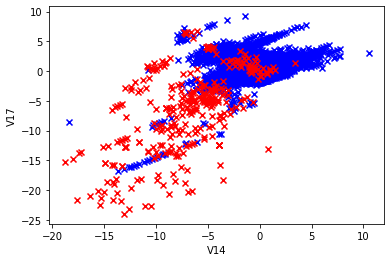

In [ ]:
feature_names = ['V14','V17']
scatter_plot(feature_names,X_train,y_train)

Since there are two distinct clusters, we can choose n_components = 2

In [ ]:
n=2
auc_score(n,feature_names,X_train,X_val,y_train,y_val)

AUC of training set --> 0.957868908681247
AUC of validation set --> 0.9627494431529802
Best threshold ---> -10.09080816346987 , Maximum F1 score --->  0.6886792452830189


**Set 2 - V14 and V10**

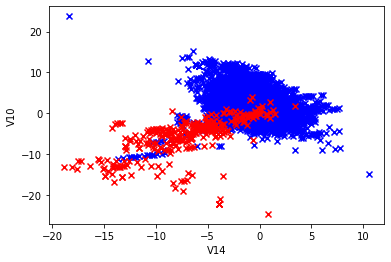

In [ ]:
feature_names = ['V14','V10']
scatter_plot(feature_names,X_train,y_train)

Since there are two distinct clusters, we can choose n_components = 2

In [ ]:
n=2
auc_score(n,feature_names,X_train,X_val,y_train,y_val)

AUC of training set --> 0.9487542853486098
AUC of validation set --> 0.963093258900845
Best threshold ---> -11.36559623534772 , Maximum F1 score --->  0.4716981132075472


**Set 3 - V4 and V5**

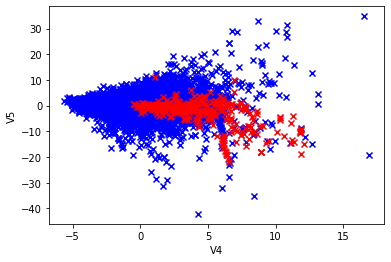

In [ ]:
feature_names = ['V4','V5']
scatter_plot(feature_names,X_train,y_train)

Since there are two distinct clusters, we can choose n_components = 1

In [ ]:
n=1
auc_score(n,feature_names,X_train,X_val,y_train,y_val)

AUC of training set --> 0.885633077429656
AUC of validation set --> 0.8885254166739947
Best threshold ---> -41.8144810713116 , Maximum F1 score --->  0.20118343195266272


**Set 4 - V17 and V10**

In [ ]:
feature_names = ['V17','V10']

Since there are two distinct clusters, we can choose n_components = 1

In [ ]:
n=1
auc_score(n,feature_names,X_train,X_val,y_train,y_val)

AUC of training set --> 0.9500041205759853
AUC of validation set --> 0.9518201026343459
Best threshold ---> -66.72609894355598 , Maximum F1 score --->  0.4722222222222222


From the 4 sets, we can find the set 1 has best AUC value, so threshold = -10.080647039646431

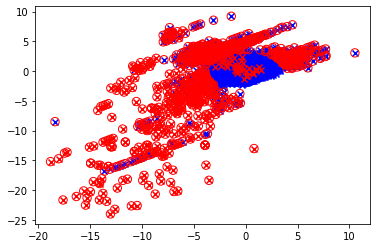

In [ ]:
threshold = -10.080647039646431
feature_names = ['V14','V17']
gm.fit(X_train.loc[:,feature_names].values)
data_train = gm.score_samples(X_train.loc[:,feature_names].values)

plt.scatter(X_train[feature_names[0]][y_train==0],X_train[feature_names[1]][y_train==0],marker='x',c='b')
plt.scatter(X_train[feature_names[0]][y_train==1],X_train[feature_names[1]][y_train==1],marker='x',c='r')

outliers = np.nonzero(data_train<threshold)[0]
plt.scatter(X_train[feature_names[0]].iloc[outliers],X_train[feature_names[1]].iloc[outliers],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

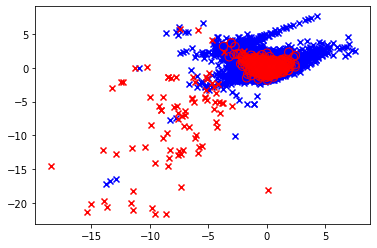

In [ ]:
threshold = -10.080647039646431
feature_names = ['V14','V17']
gm.fit(X_val.loc[:,feature_names].values)
data_train = gm.score_samples(X_val.loc[:,feature_names].values)

plt.scatter(X_val[feature_names[0]][y_val==0],X_val[feature_names[1]][y_val==0],marker='x',c='b')
plt.scatter(X_val[feature_names[0]][y_val==1],X_val[feature_names[1]][y_val==1],marker='x',c='r')

outliers = np.nonzero(data_train<threshold)[0]
plt.scatter(X_train[feature_names[0]].iloc[outliers],X_train[feature_names[1]].iloc[outliers],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

In [ ]:
###You can use the following function for 3D plotting in part b  ###

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_3d(X_train , y_train, f1, f2, f3, angle ):
  X_train_3f = pd.DataFrame(data = X_train,columns=[f1, f2,f3])
  fig = plt.figure()
  ax = plt.axes( projection='3d')
  ax.scatter3D(X_train_3f[f1][y_train==0], X_train_3f[f2][y_train==0], X_train_3f[f3][y_train==0], c='y', marker='x',label ='Non-fraud')
  ax.scatter3D(X_train_3f[f1][y_train==1], X_train_3f[f2][y_train==1], X_train_3f[f3][y_train==1], c='r', marker='o',label="Fraud")
  ax.set_xlabel(f1)
  ax.set_ylabel(f2)
  ax.set_zlabel(f3)
  plt.legend()
  ax.view_init(30, angle)
  plt.show()


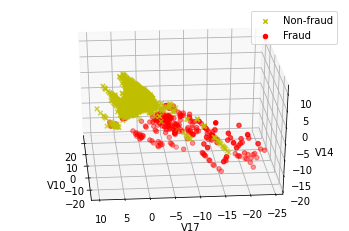

In [ ]:
plot_3d(X_train,y_train,'V10','V17','V14',175)

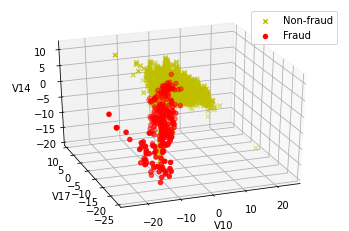

In [ ]:
plot_3d(X_train,y_train,'V10','V17','V14',250)

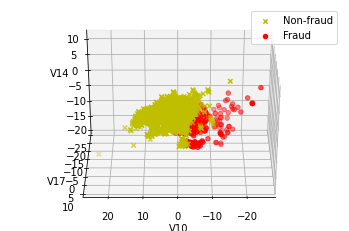

In [ ]:
plot_3d(X_train,y_train,'V10','V17','V14',90)

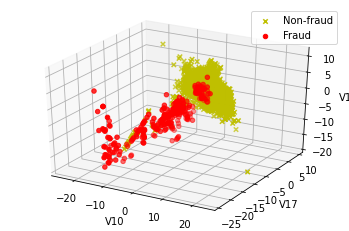

In [ ]:
plot_3d(X_train,y_train,'V10','V17','V14',300)

In [ ]:
feature_names = ['V10','V17','V14']
n=2
auc_score(n,feature_names,X_train,X_val,y_train,y_val)

AUC of training set --> 0.9569681628704376
AUC of validation set --> 0.9644933511138147
Best threshold ---> -16.37713109229732 , Maximum F1 score --->  0.5730994152046783


## **Part 4:  Two Gaussian model with single feature.**

In [ ]:
# to avoid getting warnings
import warnings
warnings.filterwarnings('ignore') 

In [ ]:
g1 = GaussianMixture(n_components = 1)
g2 = GaussianMixture(n_components = 1)
f1 = []
optimal_threshold = []
optimal_precision = []
optimal_recall = []
for item in features:
    train_non_fraudent = X_train[y_train==0][item].values.reshape(-1, 1)
    train_fraudent = X_train[y_train==1][item].values.reshape(-1, 1)
    val = X_val[item].values.reshape(-1, 1)
    g1.fit(train_non_fraudent)
    g2.fit(train_fraudent)
    s1 = g1.score_samples(val)
    s2 = g2.score_samples(val)
    max_f1_score = 0
    best_threshold = 0
    max_precision = 0
    max_recall = 0
    for threshold in np.arange(0, 10,0.1):
        outliers = np.nonzero(s1<threshold*s2)[0]
        y_pred = np.zeros(y_val.shape)
        y_pred[outliers] = 1
        f1_temp = f1_score(y_val, y_pred)
        precision_temp = precision_score(y_val,y_pred)
        recall_temp = recall_score(y_val,y_pred)
        if f1_temp>max_f1_score:
            max_f1_score=f1_temp
            best_threshold = threshold
            max_precision = precision_temp
            max_recall = recall_temp
    f1.append(max_f1_score)
    optimal_threshold.append(best_threshold)
    optimal_precision.append(max_precision)
    optimal_recall.append(max_recall)

best_feature = np.argmax(f1)
print('Best F1 score --> {0} , feature --> {1},  threshold --> {2}, precision --> {3},  recall --> {4} '.format(f1[best_feature],features[best_feature],optimal_threshold[best_feature],
                                                                                                      optimal_precision[best_feature],optimal_recall[best_feature]))


Best F1 score --> 0.6701570680628272 , feature --> V17,  threshold --> 5.9, precision --> 0.7191011235955056,  recall --> 0.6274509803921569 


In [ ]:
d = {"F1 Score": f1 ,"Threshold":optimal_threshold,"Precision":optimal_precision,"Recall":optimal_recall}
validation_set = pd.DataFrame(data=d,index=features)
validation_set

,F1 Score,Threshold,Precision,Recall
V1,0.152381,6.6,0.148148,0.156863
V2,0.175439,5.9,0.833333,0.098039
V3,0.312139,7.6,0.380282,0.264706
V4,0.377358,4.2,0.363636,0.392157
V5,0.193939,8.3,0.253968,0.156863
V6,0.118812,1.9,0.079470,0.235294
V7,0.236967,8.5,0.229358,0.245098
V8,0.104167,6.9,0.080645,0.147059
V9,0.448980,3.4,0.733333,0.323529
V10,0.397590,6.8,0.515625,0.323529


In [ ]:
g1 = GaussianMixture(n_components = 1)
g2 = GaussianMixture(n_components = 1)
f1 = []
optimal_threshold = []
optimal_precision = []
optimal_recall = []
for item in features:
    val_non_fraudent = X_val[y_val==0][item].values.reshape(-1, 1)
    val_fraudent = X_val[y_val==1][item].values.reshape(-1, 1)
    train = X_train[item].values.reshape(-1, 1)
    g1.fit(val_non_fraudent)
    g2.fit(val_fraudent)
    s1 = g1.score_samples(train)
    s2 = g2.score_samples(train)
    max_f1_score = 0
    best_threshold = 0
    max_precision = 0
    max_recall = 0
    for threshold in np.arange(0, 10,0.1):
        outliers = np.nonzero(s1<threshold*s2)[0]
        y_pred = np.zeros(y_train.shape)
        y_pred[outliers] = 1
        f1_temp = f1_score(y_train, y_pred)
        precision_temp = precision_score(y_train,y_pred)
        recall_temp = recall_score(y_train,y_pred)
        if f1_temp>max_f1_score:
            max_f1_score=f1_temp
            best_threshold = threshold
            max_precision = precision_temp
            max_recall = recall_temp
    f1.append(max_f1_score)
    optimal_threshold.append(best_threshold)
    optimal_precision.append(max_precision)
    optimal_recall.append(max_recall)

best_feature = np.argmax(f1)
print('Best F1 score --> {0} , feature --> {1},  threshold --> {2}, precision --> {3},  recall --> {4} '.format(f1[best_feature],features[best_feature],optimal_threshold[best_feature],
                                                                                                      optimal_precision[best_feature],optimal_recall[best_feature]))


Best F1 score --> 0.6830985915492956 , feature --> V12,  threshold --> 5.0, precision --> 0.7886178861788617,  recall --> 0.6024844720496895 


In [ ]:
d = {"F1 Score": f1 ,"Threshold":optimal_threshold,"Precision":optimal_precision,"Recall":optimal_recall}
training_set = pd.DataFrame(data=d,index=features)
training_set

,F1 Score,Threshold,Precision,Recall
V1,0.126697,6.6,0.123167,0.130435
V2,0.146341,5.2,0.255814,0.102484
V3,0.275591,8.1,0.376344,0.217391
V4,0.356902,4.6,0.389706,0.329193
V5,0.171429,8.1,0.221675,0.139752
V6,0.103754,1.7,0.066492,0.236025
V7,0.254181,9.8,0.275362,0.236025
V8,0.070130,9.9,0.060268,0.083851
V9,0.406321,3.4,0.743802,0.279503
V10,0.468619,7.3,0.717949,0.347826


## **Part 5: Multivariate and Mixture of Gaussians Distribution**


In [ ]:
def multivariant_gmm(n1,n2,features_names,X_train,X_val,y_train,y_val):
    g1 = GaussianMixture(n_components = n1)
    g2 = GaussianMixture(n_components = n2)
    train_non_fraudent = X_train[y_train==0][features_names].values
    train_fraudent = X_train[y_train==1][features_names].values
    val = X_val[features_names].values
    train = X_train[features_names].values
    g1.fit(train_non_fraudent)
    g2.fit(train_fraudent)
    s1_train = g1.score_samples(train)
    s2_train = g2.score_samples(train)
    s1_val = g1.score_samples(val)
    s2_val = g2.score_samples(val) 
    max_f1_t_score_train = 0
    threshold_train = 0
    max_f1_score_val = 0
    threshold_val = 0

    for c in np.linspace(0, 10,101):
        outliers = np.nonzero(s1_val<c*s2_val)[0]
        outliers_t = np.nonzero(s1_train<c*s2_train)[0]
        y_pred = np.zeros(y_val.shape)
        y_pred[outliers] = 1
        y_pred_train = np.zeros(y_train.shape)
        y_pred_train[outliers_t] = 1
        f1_score_temp_train = f1_score(y_train, y_pred_train)
        f1_score_temp_val = f1_score(y_val, y_pred)
        if f1_score_temp_val>max_f1_score_val:
            max_f1_score_val=f1_score_temp_val
            threshold_val = c
        if f1_score_temp_train>max_f1_t_score_train:
            max_f1_t_score_train=f1_score_temp_train
            threshold_train = c
    return n1,n2,max_f1_t_score_train,threshold_train,max_f1_score_val,threshold_val

In [ ]:
features_names = np.array(features)[np.array(f1)>0.5]
result = []
for n1 in range(1,3):
  for n2 in range(1,10):
    result.append(multivariant_gmm(n1,n2,features_names,X_train,X_val,y_train,y_val))

In [ ]:
print('Features chosen -->',features_names)
df = pd.DataFrame(np.array(result),columns=['n1','n2','F1 Score training','Best threshold training','F1 Score validation','Best threshold validaiton'])
display(df)
best_model = df['F1 Score validation'].idxmax()
print('The best model has the below scores:')
display(df.loc[best_model])

Features chosen --> ['V11' 'V12' 'V14' 'V16' 'V17']


,n1,n2,F1 Score training,Best threshold training,F1 Score validation,Best threshold validaiton
0,1.0,1.0,0.767551,6.3,0.785340,7.1
1,1.0,2.0,0.781199,7.2,0.797814,8.1
2,1.0,3.0,0.783034,7.3,0.795812,7.1
3,1.0,4.0,0.791069,6.7,0.810526,6.4
4,1.0,5.0,0.788553,6.7,0.810526,6.5
5,1.0,6.0,0.787270,7.8,0.812183,5.9
6,1.0,7.0,0.811502,6.3,0.818182,5.7
7,1.0,8.0,0.808307,6.3,0.814070,5.6
8,1.0,9.0,0.807631,6.3,0.820513,5.7
9,2.0,1.0,0.761905,2.6,0.783069,2.7


The best model has the below scores:


n1                           1.000000
n2                           9.000000
F1 Score training            0.807631
Best threshold training      6.300000
F1 Score validation          0.820513
Best threshold validaiton    5.700000
Name: 8, dtype: float64

## **Part 6: Evaluating performance on test set:**

The model in part 5 worked the best giving maximum F1 score of 81.25%

In [ ]:
g1 = GaussianMixture(n_components = 1)
g2 = GaussianMixture(n_components = 7)
c=6.1
features = features_names
train_non_fraudent = X_train[y_train==0][features].values
train_fraudent = X_train[y_train==1][features].values
test = X_test[features].values
g1.fit(train_non_fraudent)
g2.fit(train_fraudent)
s1 = g1.score_samples(test)
s2 = g2.score_samples(test)
outliers = np.nonzero(s1<c*s2)[0]
y_pred = np.zeros(y_test.shape)
y_pred[outliers] = 1
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Final Predictions on test data:')
print('F1 score  ---->',f1)
print('Precision  ---->', precision)
print('Recall  ---->', recall)

Final Predictions on test data:
F1 score  ----> 0.8057553956834531
Precision  ----> 0.7887323943661971
Recall  ----> 0.8235294117647058
